## Reading from an Arbitary Detector


Acquiring images from detectors which already have EPICS AreaDetector interface allows us to use standard [Ophyd interfaces]( https://blueskyproject.io/ophyd/user/explanations/area-detector.html) that are consistent amoung different detectors.

[Filestore Mixins](https://blueskyproject.io/ophyd/user/generated/ophyd.areadetector.filestore_mixins.FileStoreBase.html) allow us to easily add the ability to export files to storage and then access them later. [They mask quite a lot of complexity which is useful to understand.](https://blueskyproject.io/event-model/main/index.html) 

In this example we will not use EPICS at all and explore how the document model allows us to access files by reference later rather than transmit them over the documents. [An earlier version of this example was given at BESSY in 2019 by M. Rakitin](https://github.com/mrakitin/Berlin-2019-tutorials-workshop/blob/master/demo/LaptopCam.ipynb)

We will:

- Create an ophyd device which let's us read from a laptop camera
- Configure that ophyd device to write the images to file when they are acquired
- The location of the files will be returned and captured in resource and datum documents
- A file handler will enable the databroker to know how to read the files later so that when the user requests an image later, they just get back an xarray even if the image file is save in binary, tiff, hdf5 etc.

![DetectorsDatabroker.png](images/DetectorsDatabroker.png)


## Acquire an image with OpenCV

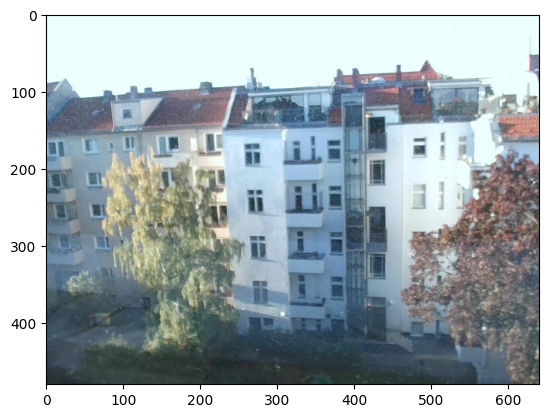

In [ ]:
import cv2
from matplotlib import pyplot as plt


det = cv2.VideoCapture(1)
_, frame = det.read()
det.release()


plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

## Set up a Bluesky Environment

We need a RunEngine, a temporary file store to keep the documents, and a count plan that handles the triggering an acquisition

In [1]:
from bluesky import RunEngine
from bluesky.plans import count
from databroker.v2 import temp

#Instantiate the Run Engine
RE = RunEngine({})

# Insert all metadata/data captured into db.
db = temp()
RE.subscribe(db.v1.insert)

0

## The Ophyd Device



In [4]:
import time
import datetime
import numpy as np
from pathlib import Path
from ophyd import Device, Component as Cpt, Signal
from ophyd.sim import NullStatus, new_uid
from ophyd.sim import deque, short_uid, itertools
import os
from ophyd.utils import make_dir_tree
import cv2


# Make a directory structure to store the image files
_ = make_dir_tree(datetime.datetime.now().year, base_path='/tmp/data')

class LaptopCam(Device):

    """
    A device which reads from the laptop camera 

    the image is saved to local storage and a reference to that data is passed to the RE in it's place

    Datum and Resource documents are generated which contain this reference

    Files are saved to /tmp/data in *.npy format

    Parameters
    ----------
    name : string, keyword only
    
    """

    # We will use this Signal to store the reference to the image
    image = Cpt(Signal)

    def __init__(self,*args, **kwargs):
        super().__init__(*args, **kwargs)
        self._save_path = str(Path('/tmp/data')/Path(datetime.datetime.now().strftime('%Y/%m/%d')))
        self._file_stem = None
        self._path_stem = None
        self._resource_uid = None
        self._datum_counter = None
        self._asset_docs_cache = deque()

        # Connect to the camera
        self.det = cv2.VideoCapture(1)
        
        
    def stage(self):
        
        # Initialise the camera
        self.det = cv2.VideoCapture(1)

        #We will use this generator later to create incrementing unique file names
        self._file_stem = short_uid()      
        self._datum_counter = itertools.count()
        self._path_stem = os.path.join(self._save_path, self._file_stem)
        
        # Make a resource document that will be used to say where the images are saved 
        # The "spec" defines the format and tells the databroker which handler to use
        #
        # One resource document is made per run
        resource = {
            "spec": 'laptop_cam',
            "root": self._save_path,
            "resource_path": self._file_stem,
            "resource_kwargs": {},
            "path_semantics": {"posix": "posix", "nt": "windows"}[os.name],
        }

        self._resource_uid = new_uid()
        resource["uid"] = self._resource_uid
        self._asset_docs_cache.append(("resource", resource))
        
    
    def trigger(self):

        # First, trigger the camera and get a reading
        _, frame = self.det.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        self._img_shape = frame.shape

        # Save the image to disk. For a real detector,
        # this part would be done by the detector IOC, not by ophyd.
        data_counter = next(self._datum_counter)
        np.save("{}_{}.npy".format(self._path_stem, data_counter), frame,allow_pickle=False)
           
        # Create the datum document which links a particular image/images
        # from an event to a single resource document
        datum_id = "{}/{}".format(self._resource_uid, data_counter)
        datum = {
            "resource": self._resource_uid,
            "datum_kwargs": dict(index=data_counter),
            "datum_id": datum_id
        }    

        # Add the datum document to the asset cache       
        self._asset_docs_cache.append(("datum", datum))

        # And now add the datum_id to the "image" Signal value
        self.image.put(datum_id)

        # Return a status object to the run engine
        return NullStatus()

    def describe(self):
        """
        This method is called by the run engine at the start of the run.
        It gives information on the value returned by read()
        """
        res = self.image.describe()
        shape = [int(self.det.get(4)),int(self.det.get(3)) ,3]
        res[self.image.name].update(dict(external="FILESTORE",dtype='array', shape= shape, precision=3))
        return res

    def collect_asset_docs(self):
        """
        Create the resource, datum, stream_resource, and stream_datum
        documents describing data in external source.
        """
        items = list(self._asset_docs_cache)
        self._asset_docs_cache.clear()
        for item in items:
            yield item

    def unstage(self):
        self._resource_uid = None
        self._datum_counter = None
        self._asset_docs_cache.clear()
        self.det.release()
    
# Instantiate the device
lc = LaptopCam(name='lc')



## Make a File Handler

We will save the image by reference rather than the image itself. We need to tell the client in the end what to do with this reference

You can read more about handlers here: https://blueskyproject.io/event-model/main/user/explanations/external.html#handler-interface

In [5]:
class LaptopCamFileHandler:
    specs = {'laptop_cam'}

    def __init__(self, filename, root=""):
        self._name = os.path.join(root, filename)

    def __call__(self, index):
        return np.load("{}_{}.npy".format(self._name, index), allow_pickle=False)

    

#Register this handler with our databroker 
db.register_handler('laptop_cam', LaptopCamFileHandler, overwrite=True)

print(db.handler_registry)

HandlerRegistryView({'NPY_SEQ': <class 'ophyd.sim.NumpySeqHandler'>, 'laptop_cam': <class '__main__.LaptopCamFileHandler'>})


## Run a Count plan

We will use a "count" plan which will trigger the detector, then read from it. We add the callback "print" so we can see the documents that are produced. 

**`Start`** document contains metadata about the measurement including plan name, versions, the "reason" etc

**`Descriptor`** document at the start which describes the type and shape of the data that will be acquired. It also includes the `external` key which tells the databroker later that there will be no image data in these documents and to look elsewhere

**`Resource`** document is next. It contains information about where to find the image files

**`Event & Datum`** documents come in pairs, one for each trigger so there are 3 in our case. The datum documents refer to the resource document id and contain information on the images acquired at each event (in this case an index number which is used in the filename)

**`Stop`** document telling us that the run finished successfully

In [6]:
RE(count([lc],3),print,reason="laptop cam demo")

start {'uid': '193dfa1f-12fd-4862-bf07-262574e37322', 'time': 1697920601.051853, 'versions': {'ophyd': '1.9.0', 'bluesky': '1.11.0'}, 'scan_id': 1, 'plan_type': 'generator', 'plan_name': 'count', 'detectors': ['lc'], 'num_points': 3, 'num_intervals': 2, 'plan_args': {'detectors': ["LaptopCam(prefix='', name='lc', read_attrs=['image'], configuration_attrs=[])"], 'num': 3}, 'hints': {'dimensions': [(('time',), 'primary')]}, 'reason': 'laptop cam demo'}
descriptor {'run_start': '193dfa1f-12fd-4862-bf07-262574e37322', 'time': 1697920601.1296847, 'data_keys': {'lc_image': {'source': 'SIM:lc_image', 'dtype': 'array', 'shape': [480, 640, 3], 'external': 'FILESTORE', 'precision': 3, 'object_name': 'lc'}}, 'uid': '26d41400-afdf-483f-8942-b047f1ee7f92', 'configuration': {'lc': {'data': {}, 'timestamps': {}, 'data_keys': OrderedDict()}}, 'name': 'primary', 'hints': {'lc': {'fields': []}}, 'object_keys': {'lc': ['lc_image']}}
resource {'spec': 'laptop_cam', 'root': '\\tmp\\data\\2023\\10\\21', 're

('193dfa1f-12fd-4862-bf07-262574e37322',)

## View the Images

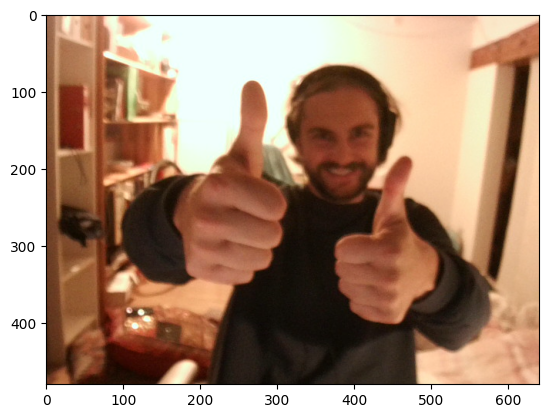

In [8]:
import matplotlib.pyplot as plt

#Access the last run data from the database
run = db[-1]

#Plot the second image acquired
plt.imshow(run.primary.read()["lc_image"][2])

## Other Useful Simulators

The `ophyd.sim` package includes a simulated Signal which is sufficient to test everything shown above. In the example below a random 100 x 100 image is generated and saved to `save_path_template`

In [9]:
from ophyd.sim import SynSignalWithRegistry
import numpy as np

save_path_template = str(Path('/tmp/data') / Path(datetime.datetime.now().strftime('%Y/%m/%d')))
img = SynSignalWithRegistry(func=lambda: np.random.rand(100,100,3) * 255, name="img",labels={"detectors"}, save_path=save_path_template)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


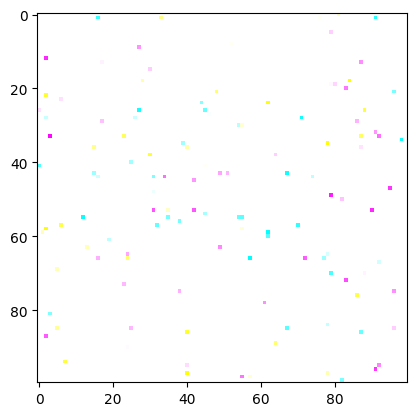

In [10]:
RE(count([img],3),reason="random number sim detector")

run = db[-1]

image = run.primary.read()['img'][1]
plt.imshow(image)